In [137]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import matplotlib.patches as mpatches
import numpy as np

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

In [138]:
# TELAS
A = 'Voile'
B = 'Rustico'
telas = [A,B]
LIMITE_PRODUCCION = 150

# PRECIOS VENTA
PRECIO_VENTA = {
    A: 420,
    B: 873,
}

# COSTOS
MT = 30
COSTO_FABRICACION = {
    A: 9*MT,
    B: 10*MT
}

COSTO_MATERIA_PRIMA = {
    A: 3*MT,
    B: 4*MT
}

COSTO_VENTA = {
    A: 20,
    B: 25
}

COSTO_COMPRA = {
    A: 430,
    B: 830
}

# STOCK
STOCK_INICIAL = {
    A: 30,
    B: 150
}

LIMITE_STOCK = {
    A: 50, #Como el máximo es 2*min, no son necesarios ambos valores
    B: 120
}
COSTO_EMBALAJE = 380
LIMITE_EMBALAJE = 950

# DEMANDA
LIMITES_DEMANDA = {
    A: (100, 800),
    B: (150, 300)
}

# VARIABLES FINANCIERAS
DISPONIBILIDAD = 50_000
LIMITES_EXCEDENTE = [0, 50_000, 150_000]
INTERVALOS_EXCEDENTE = len(LIMITES_EXCEDENTE)
PORCENTAJE_EXCEDENTE = {
    1: 0.052,
    2: 0.054
}
LIMITES_DEFICIT = [0, 50_000, 100_000]
INTERVALOS_DEFICIT = len(LIMITES_DEFICIT)
PORCENTAJE_DEFICIT = {
    1: 0.056,
    2: 0.06
}
AHORRO = 35_000
LIM_AHORRO = 350

In [139]:
mdl = Model(name="Ejericicio 3.15: Producción de telas") 

# Variables de produccion
tela_producida = {}
tela_comprada = {}
tela_vendida = {}
stock_final = {}
for tela in telas:
    tela_producida[tela] = mdl.integer_var(name=f'tela_producida_{tela}')
    tela_comprada[tela] = mdl.integer_var(name=f'tela_{tela}_comprada')
    tela_vendida[tela] = mdl.integer_var(name=f'tela_{tela}_vendida')
    stock_final[tela] = mdl.integer_var(name=f'stock_final_de_{tela}')
voile_embaladas = mdl.integer_var(name=f'telas_Voile_embaladas_extra')
# Variables financieras
excedente_i = {intervalo: mdl.integer_var(name=f'excedente_de_intervalo_{intervalo}') for intervalo in range(1, INTERVALOS_EXCEDENTE)}
excedente = mdl.integer_var(name=f'excedente')
deficit_i = {intervalo: mdl.integer_var(name=f'deficit_de_intervalo_{intervalo}') for intervalo in range(1, INTERVALOS_DEFICIT)}
deficit = mdl.integer_var(name=f'deficit')
# Variables binarias
se_produce = {tela: mdl.binary_var(name=f'se_produce_tela_{tela}') for tela in telas}
es_excedente_i = {intervalo: mdl.binary_var(name=f'es_excedente_{intervalo}') for intervalo in range(1, INTERVALOS_EXCEDENTE)}
es_deficit_i = {intervalo: mdl.binary_var(name=f'es_deficit_{intervalo}') for intervalo in range(1, INTERVALOS_DEFICIT)}
embalaje_extra = mdl.binary_var(name=f'se_compra_de_segundo_proveedor')
se_ahorra = mdl.binary_var(name=f'se_ahorra_la_suma_{AHORRO}')

ingresos = mdl.sum(PRECIO_VENTA[tela]*tela_vendida[tela] for tela in telas)
costos_produccion = mdl.sum((COSTO_FABRICACION[tela] + COSTO_MATERIA_PRIMA[tela])*tela_producida[tela] for tela in telas)
costos_compra = mdl.sum(COSTO_COMPRA[tela]*tela_comprada[tela] for tela in telas)
costos_venta = COSTO_VENTA['Voile']*tela_vendida['Voile'] + COSTO_VENTA['Rustico']*tela_vendida['Rustico'] 
+ COSTO_EMBALAJE*voile_embaladas
ganancia_excedente = mdl.sum(excedente_i[intervalo]*PORCENTAJE_EXCEDENTE[intervalo] for intervalo in range(1, INTERVALOS_EXCEDENTE))
interes_deficit = mdl.sum(deficit_i[intervalo]*PORCENTAJE_DEFICIT[intervalo] for intervalo in range(1, INTERVALOS_DEFICIT))
ahorro = AHORRO*se_ahorra

# --Restricciones--
# Balance vendidas + stock final = producidas + compradas + stock inicial
mdl.add_constraint(
    tela_vendida['Rustico'] + stock_final['Rustico'] == tela_producida['Rustico'] + tela_comprada['Rustico'] + STOCK_INICIAL['Rustico']
    )
mdl.add_constraint(
    tela_vendida['Voile'] + stock_final['Voile'] == tela_producida['Voile'] + voile_embaladas + tela_comprada['Voile'] + STOCK_INICIAL['Voile']
    )
# Demanda
for tela in telas:
    mdl.add_constraint(tela_vendida[tela] >= LIMITES_DEMANDA[tela][0])
    mdl.add_constraint(tela_vendida[tela] <= LIMITES_DEMANDA[tela][1])
# Stock
for tela in telas:
    mdl.add_constraint(stock_final[tela] >= LIMITE_STOCK[tela])
    mdl.add_constraint(stock_final[tela] <= 2 * LIMITE_STOCK[tela])
# Financiero
mdl.add_constraint(
    DISPONIBILIDAD + ingresos - 0.5*(costos_compra + costos_produccion + costos_venta) == DISPONIBILIDAD + excedente - deficit
    )
mdl.add_constraint(excedente == mdl.sum(excedente_i[intervalo] for intervalo in range(1, INTERVALOS_EXCEDENTE)))
mdl.add_constraint(deficit == mdl.sum(deficit_i[intervalo] for intervalo in range(1, INTERVALOS_DEFICIT)))
for i in range(1,INTERVALOS_EXCEDENTE):
    mdl.add_constraint(excedente_i[i] >= (LIMITES_EXCEDENTE[i-1]+0.1) * es_excedente_i[i])
    mdl.add_constraint(excedente_i[i] <= LIMITES_EXCEDENTE[i] * es_excedente_i[i])
mdl.add_constraint(mdl.sum(es_excedente_i[intervalo] for intervalo in range(1, INTERVALOS_EXCEDENTE)) <= 1)
for i in range(1,INTERVALOS_DEFICIT):
    mdl.add_constraint(deficit_i[i] >= (LIMITES_DEFICIT[i-1]+0.1) * es_deficit_i[i])
    mdl.add_constraint(deficit_i[i] <= LIMITES_DEFICIT[i] * es_deficit_i[i])
mdl.add_constraint(mdl.sum(es_deficit_i[intervalo] for intervalo in range(1, INTERVALOS_DEFICIT)) <= 1)
# Si se compra, no se produce
M1 = 10000
for tela in telas:
    mdl.add_constraint(tela_producida[tela] >= LIMITE_PRODUCCION * se_produce[tela])
    mdl.add_constraint(tela_producida[tela] <= M1 * se_produce[tela])
    mdl.add_constraint(tela_comprada[tela] <= M1*(1 - se_produce[tela]))
# Ahorro
mdl.add_constraint(mdl.sum(tela_producida[tela] for tela in telas) >= LIM_AHORRO * se_ahorra)
# Voile embaladas
M2 = 10000
telas_producidas = tela_producida['Rustico'] + tela_producida['Voile']
LIMITE_EMBALAJE = 950
mdl.add_constraint(telas_producidas >= LIMITE_EMBALAJE * embalaje_extra)
mdl.add_constraint(telas_producidas <= LIMITE_EMBALAJE)
mdl.add_constraint(voile_embaladas <= M2*embalaje_extra)

# Funcion objetivo
beneficio = ingresos - costos_produccion - costos_compra - costos_venta + ganancia_excedente - interes_deficit + ahorro
mdl.maximize(beneficio)
solution = mdl.solve()

# --- Imprimir información ---
mdl.print_information()

Model: Ejericicio 3.15: Producción de telas
 - number of variables: 23
   - binary=8, integer=15, continuous=0
 - number of constraints: 33
   - linear=33
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


In [140]:
# Imprimir la solución
if solution:
    print(f'BENEFICIO:')
    print(f' - ${mdl.objective_value:.2f}')
    
else:
    print("No se encontro solución.")

BENEFICIO:
 - $121745.73


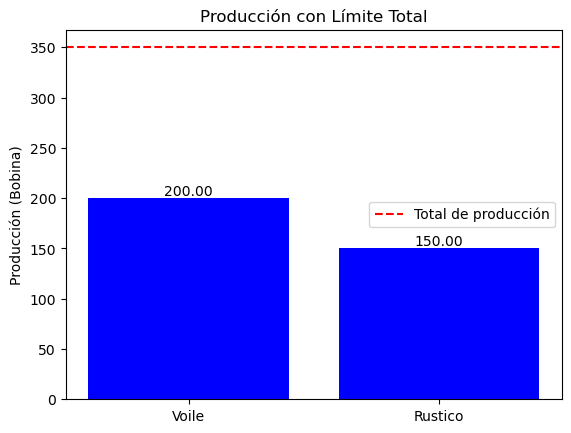

In [141]:
# Datos necesarios
telas_producidas_graph = {tela: tela_producida[tela].solution_value for tela in telas if tela_producida[tela].solution_value > 0}
total = sum(telas_producidas_graph.values())

fig, ax = plt.subplots()
bars = ax.bar(telas_producidas_graph.keys(), telas_producidas_graph.values(), color='blue')
ax.axhline(y=total, color='r', linestyle='--', label='Total de producción')
ax.set_ylabel('Producción (Bobina)')
ax.set_title('Producción con Límite Total')
ax.legend()

# Mostrar el valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

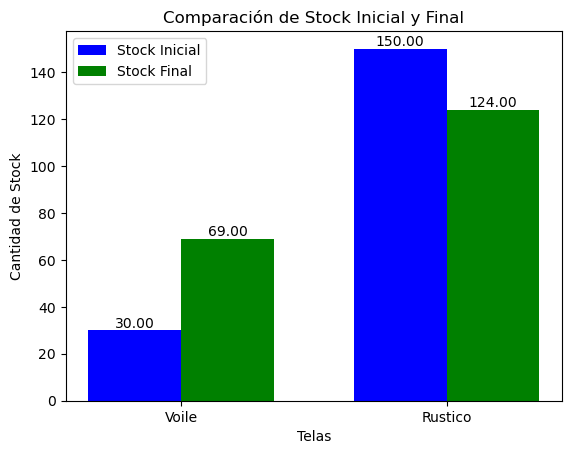

In [142]:
# Datos de ejemplo: Stocks iniciales y finales
stocks_finales = {tela : stock_final[tela].solution_value for tela in telas}

# Crear etiquetas y valores para el gráfico
telas = list(STOCK_INICIAL.keys())  # ['A', 'B']
iniciales = list(STOCK_INICIAL.values())
finales = list(stocks_finales.values())

# Configurar posición de las barras
x = np.arange(len(telas))  # posiciones para las barras

# Ancho de las barras
ancho_barras = 0.35

# Crear gráfico
fig, ax = plt.subplots()

# Graficar stocks iniciales y finales
barras_iniciales = ax.bar(x - ancho_barras/2, iniciales, ancho_barras, label='Stock Inicial', color='blue')
barras_finales = ax.bar(x + ancho_barras/2, finales, ancho_barras, label='Stock Final', color='green')

for bar in barras_iniciales:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

for bar in barras_finales:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

# Agregar etiquetas y título
ax.set_xlabel('Telas')
ax.set_ylabel('Cantidad de Stock')
ax.set_title('Comparación de Stock Inicial y Final')
ax.set_xticks(x)
ax.set_xticklabels(telas)

# Agregar leyenda
ax.legend()

# Mostrar gráfico
plt.show()

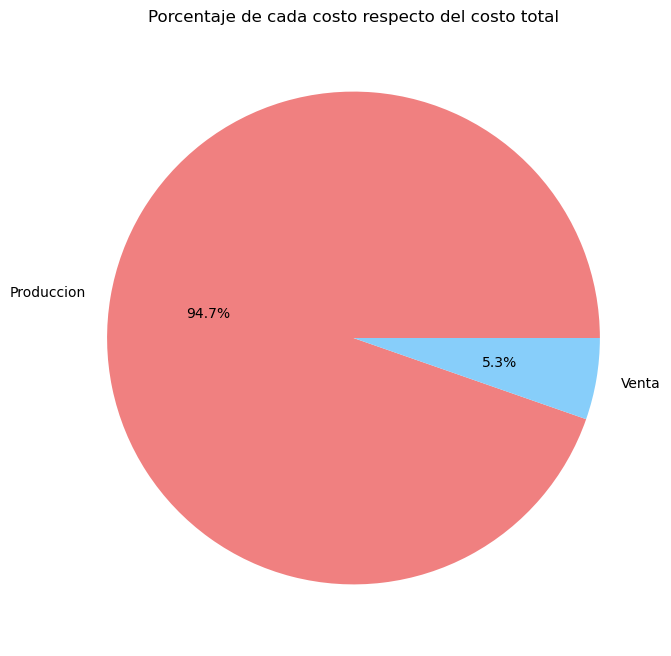

In [143]:
# Datos necesarios
costos = {
    "Produccion" : costos_produccion.solution_value,
    "Compra" : costos_compra.solution_value,
    "Venta" : costos_venta.solution_value
}
total = sum(costos.values())
porcentaje_costos = {tipo: (valor / total) * 100 for tipo, valor in costos.items() if valor > 0}

# Gráfico de pastel para representar el porcentaje de cada aceite en el producto final
plt.figure(figsize=(8, 8))
plt.pie(porcentaje_costos.values(), labels=porcentaje_costos.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'lightpink'])
plt.title('Porcentaje de cada costo respecto del costo total')
plt.show()